# Breaching privacy - test parameter modifications

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

In [2]:
import matplotlib.pyplot as plt 

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [3]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=modern', 'case.model=resnet50', 'case/data=CIFAR10'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda:3') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 8
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: false
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: cosine-decay
  langevin_noise: 0.1
  warmup: 50
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 2
    outer_exp: 0.5
    double_opponents: true
  orthogonality:
    scale: 0.0
  norm:
    scale: 1.0e-06
    pnorm: 2
  deep_inversion:
    scale: 0.01



/home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'cfg': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


{'device': device(type='cuda', index=3), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [23]:
# cfg.dryrun = False
# cfg.attack.optim.step_size=1.0
cfg.case.user.data_idx = 0
cfg.case.model = 'resnet18'
#cfg.case.server.model_state='moco'

cfg.case.user.num_data_points = 4

cfg.attack.restarts.num_trials=1
cfg.attack.regularization.deep_inversion.scale=0.01
cfg.attack.regularization.total_variation.scale=0.05
cfg.attack.regularization.norm.scale=0.0
cfg.attack.optim.langevin_noise=0.0

### Instantiate all parties

In [24]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified


In [25]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 4
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ResNet
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


In [26]:
cfg.case.model

'resnet18'

In [30]:
sum([p.numel() for p in user.model.parameters()]) / 3 / 32 / 32 / 512

7.104213714599609

### Simulate an attacked FL protocol

In [8]:
[(idx, val[0], val[1].shape) for idx, val in enumerate(server.model.named_parameters())]

[(0, 'stem.0.weight', torch.Size([64, 3, 3, 3])),
 (1, 'stem.1.weight', torch.Size([64])),
 (2, 'stem.1.bias', torch.Size([64])),
 (3, 'layers.0.0.conv1.weight', torch.Size([64, 64, 1, 1])),
 (4, 'layers.0.0.bn1.weight', torch.Size([64])),
 (5, 'layers.0.0.bn1.bias', torch.Size([64])),
 (6, 'layers.0.0.conv2.weight', torch.Size([64, 64, 3, 3])),
 (7, 'layers.0.0.bn2.weight', torch.Size([64])),
 (8, 'layers.0.0.bn2.bias', torch.Size([64])),
 (9, 'layers.0.0.conv3.weight', torch.Size([256, 64, 1, 1])),
 (10, 'layers.0.0.bn3.weight', torch.Size([256])),
 (11, 'layers.0.0.bn3.bias', torch.Size([256])),
 (12, 'layers.0.0.downsample.0.weight', torch.Size([256, 64, 1, 1])),
 (13, 'layers.0.0.downsample.1.weight', torch.Size([256])),
 (14, 'layers.0.0.downsample.1.bias', torch.Size([256])),
 (15, 'layers.0.1.conv1.weight', torch.Size([64, 256, 1, 1])),
 (16, 'layers.0.1.bn1.weight', torch.Size([64])),
 (17, 'layers.0.1.bn1.bias', torch.Size([64])),
 (18, 'layers.0.1.conv2.weight', torch.Size([

In [18]:
def plot_map(feature_map):
    min_val, max_val = feature_map.amin(dim=[2,3], keepdim=True), feature_map.amax(dim=[2,3], keepdim=True)
    renorm_map = (feature_map - min_val) / (max_val - min_val)
    plt.imshow(renorm_map[0, :3].permute(1, 2, 0).detach().cpu())

In [19]:
with torch.no_grad():
    for module in server.model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.weight.data = module.running_var.data.clone()
            module.bias.data = module.running_mean.data.clone() + 10
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.zeros_(module.weight)
    for name, module in server.model.named_modules():
        if 'downsample.0' in name:
            torch.nn.init.dirac_(module.weight)
torch.nn.init.dirac_(server.model.stem[0].weight);

In [20]:
feature_shapes = dict()
features = dict()
def named_hook(name):
    def hook_fn(module, input, output):
        feature_shapes[name] = [input[0].shape, str(module)]
        features[name] = input[0]
    return hook_fn

hooks_list = []
for name, module in user.model.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        hooks_list.append(module.register_forward_hook(named_hook(name)))
        
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# True user data is returned only for analysis
[h.remove() for h in hooks_list];

feature_shapes

{'stem.0': [torch.Size([4, 3, 32, 32]),
  'Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)'],
 'layers.0.0.conv1': [torch.Size([4, 64, 32, 32]),
  'Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)'],
 'layers.0.0.conv2': [torch.Size([4, 64, 32, 32]),
  'Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)'],
 'layers.0.0.conv3': [torch.Size([4, 64, 32, 32]),
  'Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)'],
 'layers.0.0.downsample.0': [torch.Size([4, 64, 32, 32]),
  'Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)'],
 'layers.0.1.conv1': [torch.Size([4, 256, 32, 32]),
  'Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)'],
 'layers.0.1.conv2': [torch.Size([4, 64, 32, 32]),
  'Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)'],
 'layers.0.1.conv3': [torch.Size([4, 64, 32, 32]),
  'Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)'],


[torch.Size([4, 256, 32, 32]), 'Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)']


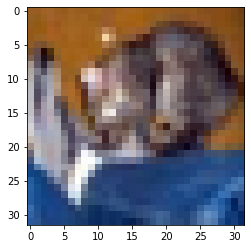

In [22]:
idx = 'layers.1.0.conv1'
plot_map(features[idx])
print(feature_shapes[idx])

['cat', 'airplane', 'horse', 'frog']


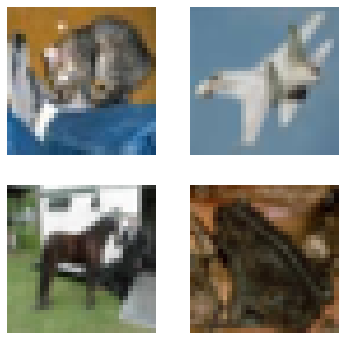

In [31]:
user.plot(true_user_data)

### Reconstruct user data [via optimization]:

In [ ]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, 
                                    true_user_data, server_payload, server.model, setup)

In [ ]:
user.plot(reconstructed_user_data)

In [ ]:
attacker.regularizers

In [ ]:
user.plot(reconstructed_user_data)